<a href="https://colab.research.google.com/github/nahumsa/pennylane-notebooks/blob/main/Meta-VQE%20Pennylane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
! pip install pennylane
clear_output()

# Meta-Variational Quantum Eigensolver

by Nahum Sá (nahumsa@cbpf.br)

# 1) Introduction

The Meta-VQE algorithm is a variational quantum algorithm that is suited for NISQ devices and encodes parameters of a Hamiltonian into a variational ansatz which we can obtain good estimations of the ground state of the Hamiltonian by changing only those encoded parameters. 

This leads to a advantage when compared with the original VQE algorithm, because if you want to know the profile of a parametrized Hamiltonian you would need to run the VQE algorithm for each parameter, using Meta-VQE you would only need to run for a fixed set of training parameters and in order to get the profile you would only need to change the parameters of the ansatz.

The Meta-VQE algorithm consists of two parts: 

- Encoding;
- Processing;

Consider a parametrized Hamiltonian $H(\vec{\lambda})$, where $\vec{\lambda} = \{ \lambda_1, \dots, \lambda_p \}$. The circuit is initialized in the $| 0 \rangle^{\otimes n}$ and then a encoding layer is added to the circuit, this layer encodes parameters of the Hamiltonian and has training parameters as well. The encoding layer is a unitary $\mathcal{S} = \mathcal{S}(\vec{\theta}_{\mathrm{enc}}, \vec{\lambda})$. After the encoding layer, we add a processing layer which is a unitary $\mathcal{U} = \mathcal{U}(\vec{\theta}_{\mathrm{proc}})$ which consists only of training parameters.

Thus the ansatz can be written as:

$$
| \psi_i \rangle = \mathcal{U}(\vec{\theta}_{\mathrm{proc}}) \ \mathcal{S}(\vec{\theta}_{\mathrm{enc}}, \vec{\lambda}) \ | 0 \rangle^{\otimes n }
$$

After constructing the ansatz we generate a set of training parameters ($\lambda_i$), which we minimize the cost function:

$$
\mathcal{L}_{\mathrm{COST}} = \sum_{i=1}^M \langle \psi_i | H (\lambda_i) | \psi_i \rangle
$$

And get optimal parameters $\vec{\theta}^*$ and use them to evaluate other parameters of the parametrized Hamiltonian which are not in the training set.

For this demo I will be using the XXZ spin chain just like the original [Meta-VQE paper](https://arxiv.org/abs/2009.13545) and is based on the [demo](https://github.com/AlbaCL/qhack21/blob/main/Meta-VQE.ipynb) by Alba Cervera-Lierta written using [Tequila](https://github.com/aspuru-guzik-group/tequila).

## 1.1) Constructing the Hamiltonian

The XXZ spin chain has the following Hamiltonian:

$$
\mathcal{H} = \sum_{i=1}^N \big( X_i X_{i+1} + Y_i Y_{i+1} + \Delta Z_i Z_{i+1} \big) + \eta \sum_{i=1}^N Z_i
$$

Where $\Delta$ is the anisotropy parameter and $\lambda$ the transverse field strenght. This model is interesting because it has two phase transitions when $\lambda=0$, at $\Delta = \pm 1$. Other feature of this model is that for $\Delta < -1$ the ground state is a product state and if $1 < \Delta \leq 1$ the ground state is highly entangled.

I will use periodic boundary conditions, which means that the last spin will have connectivity with the first spin on the chain.

The great question is: **Is it possible to create an ansatz that generate states for any $n$ and $\Delta$?**

This is where the Meta-VQE comes to rescue!



In [ ]:
# Imports
import numpy as np
import pennylane as qml
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
def hamiltonian_XXZ(n_qubits: int, delta: float, eta: float) -> qml.Hamiltonian:
    """ Creates the XXZ hamiltonian, which is given by:

    $$
    \mathcal{H} = \sum_{i=1}^N \big( X_i X_{i+1} + Y_i Y_{i+1} 
    + \Delta Z_i Z_{i+1} \big) + \eta \sum_{i=1}^N Z_i
    $$

    Args:
        n_qubits(int): number of spins in the chain.
        delta(float): delta parameter.
        eta(float): eta parameter.
    """
    hamiltonian = []
    coeffs = []
    
    # Periodic Boundary Conditions
    for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
        hamiltonian.append(op(n_qubits-1)@op(0))
        if op != qml.PauliZ :
            coeffs.append(1.)
        else:
            coeffs.append(delta)
    
    hamiltonian.append(qml.PauliZ(n_qubits-1))
    coeffs.append(eta)

    for qubits in range(n_qubits - 1):
        for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
            
            hamiltonian.append(op(qubits)@op(qubits+1))
            
            if op != qml.PauliZ :
                coeffs.append(1.)
            else:
                coeffs.append(delta)
        
        hamiltonian.append(qml.PauliZ(qubits))
        coeffs.append(eta)

    H = qml.Hamiltonian(coeffs, hamiltonian, simplify=True)
    return H

def hamiltonian_to_matrix(H: qml.Hamiltonian) -> np.array:
    """ Converts a pennylane Hamiltonian object into a matrix.

    Args:
        H(qml.Hamiltonian): Hamiltonian.

    Output:
        np.array: Outputs the matrix representation of the Hamiltonian.
    """
    mat = np.zeros((2**n_qubits, 2**n_qubits), np.complex128)
    for coef, op in zip(*H.terms):
        mat += coef*qml.utils.expand(op.matrix, op.wires, n_qubits)
    return mat

def exact_gs(H: qml.Hamiltonian) -> float:
    """ Calculates the Ground State energy of the Hamiltonian.

    Args:
        H(qml.Hamiltonian): Hamiltonian.

    Output:
        float: outputs the ground state energy of the Hamiltonian.
    """
    matrix = hamiltonian_to_matrix(H)
    energies = np.linalg.eigvals(matrix)
    return np.real(min(energies))

In [ ]:
n_qubits = 2
delta = 2.
eta = 2.
H = hamiltonian_XXZ(n_qubits, delta, eta)
print(H)

(2.0) [X1 X0]
+ (2.0) [Y1 Y0]
+ (4.0) [Z1 Z0]
+ (2.0) [Z1]
+ (2.0) [Z0]


## 1.2) Creating the ansatz

In order to create an ansatz it is needed to do an encoding of the Hamiltonian parameter. For this case I choose to do a linear encoding of the parameter $\Delta$ of the XXZ Hamiltonian:

$$
S(\Delta, \theta) = R_Z ( \theta_0 \ \Delta + \theta_1) R_Y ( \theta_2 \ \Delta + \theta_3)
$$

For the processing layer, U, we have that:

$$
U(\theta) = R_Z ( \theta_0 ) R_Y ( \theta_1)
$$

In [ ]:
def variational_ansatz(params: np.array, delta: float , wires: qml.wires, H=None):
    """ Variational ansatz with linear encoding.


    """
    
    n_layers = params.shape[0]
    n_qubits = params.shape[1]

    for L in range(n_layers):
        # Encoding Layer
        if L == 0:
            for qubit in range(n_qubits):
                qml.RZ(params[L][qubit][0] * delta + params[L][qubit][1], wires=qubit)
                qml.RY(params[L][qubit][2] * delta + params[L][qubit][3], wires=qubit)
            
            for ent in range(0, n_qubits - 1, 2):
                qml.CNOT(wires= [ent, ent+1])
        
        # Processing Layer
        else:
            for qubit in range(n_qubits):
                qml.RZ(params[L][qubit][0] , wires=qubit)
                qml.RY(params[L][qubit][2] , wires=qubit)
            
            for ent in range(0, n_qubits - 1, 2):
                qml.CNOT(wires= [ent, ent+1])

# 1.3) Defining the cost function

The main idea for the cost function is to minimize the energy value over all training points (encoded parameters of the Hamiltonian) $H(\lambda_i)$, thus I choose the same cost function as the original paper:

$$
\mathcal{L}_{\mathrm{COST}} = \sum_{i=1}^M \langle \psi_i | H (\lambda_i) | \psi_i \rangle
$$

By minimizing this cost function it is expected to find the ground state by only changing the parameters $\lambda_i$ on the parametrized wave function $| \psi_i \rangle$.

In order to construct the loss function using Pennylane, it is needed to first construct a general way to calculate the expected value of a hamiltonian given an ansatz, which is done on the `ExpvalH`, and then it is neede to calculate the cost of the XXZ Hamiltonian for each training points of the parameter $\delta$.

In [ ]:
def ExpvalH(H: qml.Hamiltonian, device: qml.device):
    coeffs, observables = H.terms
    qnodes = qml.map(
            variational_ansatz, observables, device
            )
    cost = qml.dot(coeffs, qnodes)
    return cost

def m_vqe_cost(train_deltas: np.array, dev: qml.device , params: np.array):
    # cost function value
    c = 0.
    n_qubits = dev.num_wires

    for delta in train_deltas:
        H = hamiltonian_XXZ(n_qubits, delta, eta)
        cost = ExpvalH(H, dev)
        c += cost(params, delta=delta)
    
    return c

Let's define the parameters to run the algorithm. First we define the training values of $\delta$ which is taken to be a uniform distrubution between -1.1 and 1.1. 

Next we define the eta to be 0.75 as the original paper, and then define the number of encoded and processing layers.

After that we initialize the parameters at random. 

In [ ]:
# Creating training data
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

train_deltas = np.random.uniform(low=-1, high=1, size=5)

seed
# Hyperparameters
eta = 0.75 # lambda parameter
L = 4 # Number of layers

# initializing parameters
params = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=(L, n_qubits, 4))

# Training Parameters
epochs = 100
optimizer = qml.AdagradOptimizer()

from functools import partial

# Applyies train_deltas for the Meta-VQE cost function
cost_fn = partial(m_vqe_cost, train_deltas, dev)

pbar = tqdm(range(epochs), desc='Energy', leave=True)

for i in pbar:
    params, val = optimizer.step_and_cost(cost_fn, params)
    pbar.set_description(f"Loss: {val:.3f}")

params_mvqe = params.copy()

## 1.3) Testing the trained model

Now we compare the trained ansatz with the exact solution and see that it "learns" the shape of the exact solution, but it has some offset.

In [ ]:
# Creating test data
test_deltas = np.random.uniform(low=-1, high=1, size=50)
test_energies = np.zeros_like(test_deltas)
exact_energies = np.zeros_like(test_deltas)

n_qubits = dev.num_wires

for i, delta in tqdm(enumerate(test_deltas)):
    H = hamiltonian_XXZ(n_qubits, delta, eta)
    cost = ExpvalH(H, dev)
    test_energies[i] = cost(params_mvqe, delta=delta)
    exact_energies[i] = exact_gs(H)

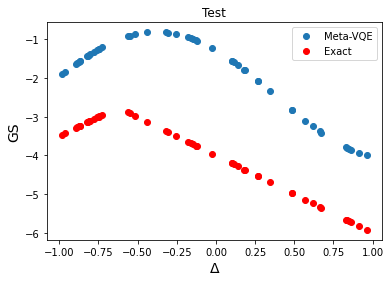

In [ ]:
plt.plot(test_deltas, test_energies, 'o', label='Meta-VQE')
plt.plot(test_deltas, exact_energies, 'ro', label='Exact')
plt.title("Test")
plt.xlabel("$\Delta$", fontsize=14)
plt.ylabel("GS", fontsize=14)
plt.legend()
plt.show()

# References

[1] [Cervera-Lierta, Alba, Jakob S. Kottmann, and Alán Aspuru-Guzik. "The meta-variational quantum eigensolver (meta-vqe): Learning energy profiles of parameterized hamiltonians for quantum simulation." arXiv preprint arXiv:2009.13545 (2020)](https://arxiv.org/abs/2009.13545).

[2] [Alba Cervera-Lierta QHACK21 repository](https://github.com/AlbaCL/qhack21/blob/main/Meta-VQE.ipynb)